In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import plotly.graph_objs as go
from torchsummary import summary
from sklearn.model_selection import train_test_split
from torchview import draw_graph


import warnings
warnings.filterwarnings('ignore')

In [51]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# print(device)

In [52]:
np.random.seed(0)
torch.manual_seed(0)

# Y = X@A.T + bias
n_samples = 100
X = np.random.rand(n_samples, 2)
Y = 3 * X[:,0] + 5 * X[:,1] + np.random.normal(0.0, 1.0, n_samples) 

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

# y_true = f(x) + noise
# y_pred = f_hat(x)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(80, 2) (80,)
(20, 2) (20,)


In [53]:
X[:10]

array([[0.5488135 , 0.71518937],
       [0.60276338, 0.54488318],
       [0.4236548 , 0.64589411],
       [0.43758721, 0.891773  ],
       [0.96366276, 0.38344152],
       [0.79172504, 0.52889492],
       [0.56804456, 0.92559664],
       [0.07103606, 0.0871293 ],
       [0.0202184 , 0.83261985],
       [0.77815675, 0.87001215]])

In [54]:
x_surf, y_surf = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), n_samples),
                             np.linspace(X[:, 1].min(), X[:, 1].max(), n_samples))

z_true_surf = 3 * x_surf + 5 * y_surf  # True surface

# Create a plotly figure
fig = go.Figure()

# Add true training data
fig.add_trace(go.Scatter3d(x=X_train[:, 0], y=X_train[:, 1], z=Y_train, mode='markers', marker=dict(color='blue'), name='True Data (Training)'))

# Add true validation data
fig.add_trace(go.Scatter3d(x=X_val[:, 0], y=X_val[:, 1], z=Y_val, mode='markers', marker=dict(color='green'), name='True Data (Validation)'))


# Add true surface
fig.add_trace(go.Surface(x=x_surf, y=y_surf, z=z_true_surf, opacity=0.5, colorscale='blues', name='True Surface'))

# Layout
fig.update_layout(scene=dict(
                    xaxis_title='Feature 1',
                    yaxis_title='Feature 2',
                    zaxis_title='Target'),
                    legend=dict(y=0.5, font_size=12),
                    margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

In [55]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).reshape(-1, 1)

print(X_train_tensor.size(), Y_train_tensor.size())
print(X_val_tensor.size(), Y_val_tensor.size())

torch.Size([80, 2]) torch.Size([80, 1])
torch.Size([20, 2]) torch.Size([20, 1])


In [56]:
class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.fc_layer1 = nn.Linear(2, 128)
        self.fc_layer2 = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        fc_1 = self.fc_layer1(x)
        fc_1 = self.relu(fc_1)
        fc_2 = self.fc_layer2(fc_1)
        fc_2 = self.sigmoid(fc_2)
        output = self.output_layer(fc_2)
        return output

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
           Sigmoid-4                  [-1, 128]               0
            Linear-5                    [-1, 1]             129
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


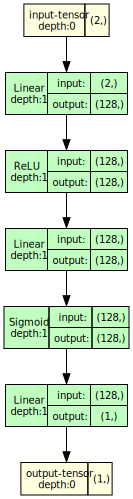

In [57]:
model = FFNN()
summary(model, input_size=(2,))
model_graph = draw_graph(model, input_size=(2,), expand_nested=True)
model_graph.visual_graph

In [58]:
# del model

In [59]:
# define loss function
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

num_epochs = 10000
train_losses = []
valid_losses = []
batch_size = 10

In [60]:
# model.to(device)
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train_tensor[i:i+batch_size] # 0-10, 10-20
        Y_batch = Y_train_tensor[i:i+batch_size]

        # forward pass
        outputs = model(X_batch)
        loss = loss_function(outputs, Y_batch)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train_tensor)
        train_loss = loss_function(train_outputs, Y_train_tensor)
        train_losses.append(train_loss)

        valid_output = model(X_val_tensor)
        valid_loss = loss_function(valid_output, Y_val_tensor)
        valid_losses.append(valid_loss)

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

Epoch [100/10000], Training Loss: 0.9646, Validation Loss: 0.6275
Epoch [200/10000], Training Loss: 0.8544, Validation Loss: 0.6931
Epoch [300/10000], Training Loss: 0.8394, Validation Loss: 0.7560
Epoch [400/10000], Training Loss: 0.8285, Validation Loss: 0.8019
Epoch [500/10000], Training Loss: 0.8194, Validation Loss: 0.8413
Epoch [600/10000], Training Loss: 0.8102, Validation Loss: 0.8752
Epoch [700/10000], Training Loss: 0.7997, Validation Loss: 0.9088
Epoch [800/10000], Training Loss: 0.7875, Validation Loss: 0.9390
Epoch [900/10000], Training Loss: 0.7750, Validation Loss: 0.9677
Epoch [1000/10000], Training Loss: 0.7621, Validation Loss: 1.0002
Epoch [1100/10000], Training Loss: 0.7531, Validation Loss: 1.0319
Epoch [1200/10000], Training Loss: 0.7460, Validation Loss: 1.0556
Epoch [1300/10000], Training Loss: 0.7392, Validation Loss: 1.0719
Epoch [1400/10000], Training Loss: 0.7331, Validation Loss: 1.0827
Epoch [1500/10000], Training Loss: 0.7290, Validation Loss: 1.0949
Epoc

In [61]:
epochs = np.arange(1, num_epochs + 1)
fig_losses = go.Figure()
fig_losses.add_trace(go.Scatter(x=epochs, y=train_losses, mode='lines', name='Training Loss'))
fig_losses.add_trace(go.Scatter(x=epochs, y=valid_losses, mode='lines', name='Validation Loss'))
fig_losses.update_layout(title='Training and Validation Losses',
                         xaxis_title='Epoch',
                         yaxis_title='Loss')

In [62]:
# Create a meshgrid for plotting the true and predicted surfaces
x_surf, y_surf = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), n_samples),
                             np.linspace(X[:, 1].min(), X[:, 1].max(), n_samples))

z_true_surf = 3 * x_surf + 5 * y_surf  # True surface
z_predicted_surf = model(torch.tensor(np.vstack((x_surf.flatten(), y_surf.flatten())).T, dtype=torch.float32)).detach().numpy().reshape(x_surf.shape)

# Create a plotly figure
fig = go.Figure()

# Add true function data
fig.add_trace(go.Scatter3d(x=X_train[:, 0], y=X_train[:, 1], z=Y_train, mode='markers', marker=dict(color='blue'), name='Training Data'))

# Add true function data
fig.add_trace(go.Scatter3d(x=X_val[:, 0], y=X_val[:, 1], z=Y_val, mode='markers', marker=dict(color='green'), name='Validation Data'))

# Add true surface
fig.add_trace(go.Surface(x=x_surf, y=y_surf, z=z_true_surf, opacity=0.5, colorscale='blues', name='True Surface'))

# Add predicted surface
fig.add_trace(go.Surface(x=x_surf, y=y_surf, z=z_predicted_surf, opacity=0.5, colorscale='reds', name='Predicted Surface'))

# Layout
fig.update_layout(scene=dict(
                    xaxis_title='Feature 1',
                    yaxis_title='Feature 2',
                    zaxis_title='Target'),
                    legend=dict(y=0.5, font_size=12),
                    margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()